In [36]:
# Load our libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

# Use a nicer style for plots
plt.style.use("seaborn-v0_8-muted")

In [37]:
target_data = pd.read_csv("../Final_Data/Cleaned/10Targcleaned.csv")


In [38]:
target_data.head(10)

,Datum/Zeit,timestamp_text,PM10 (Stundenmittelwerte),PM2.5 (Stundenmittelwerte),O3 (Stundenmittelwerte),NO2 (Stundenmittelwerte),geo_point_2d
0,2021-11-30 23:00:00+00:00,2021-12-01 00:00:00,7.456,7.023,38.615,24.832,"47.5659354, 7.58192"
1,2021-12-01 00:00:00+00:00,2021-12-01 01:00:00,4.832,2.241,67.784,3.288,"47.5659354, 7.58192"
2,2021-12-01 01:00:00+00:00,2021-12-01 02:00:00,4.682,2.092,70.599,2.459,"47.5659354, 7.58192"
3,2021-12-01 02:00:00+00:00,2021-12-01 03:00:00,5.035,2.398,70.212,2.954,"47.5659354, 7.58192"
4,2021-12-01 03:00:00+00:00,2021-12-01 04:00:00,5.102,2.345,75.184,2.432,"47.5659354, 7.58192"
5,2021-12-01 04:00:00+00:00,2021-12-01 05:00:00,4.612,1.982,77.852,2.211,"47.5659354, 7.58192"
6,2021-12-01 05:00:00+00:00,2021-12-01 06:00:00,4.498,1.763,75.796,3.302,"47.5659354, 7.58192"
7,2021-12-01 06:00:00+00:00,2021-12-01 07:00:00,5.400,1.935,75.558,5.388,"47.5659354, 7.58192"
8,2021-12-01 07:00:00+00:00,2021-12-01 08:00:00,5.397,2.041,63.345,19.041,"47.5659354, 7.58192"
9,2021-12-01 08:00:00+00:00,2021-12-01 09:00:00,6.484,2.574,47.272,37.265,"47.5659354, 7.58192"


In [39]:

target_data2 = target_data[['Datum/Zeit', 'PM10 (Stundenmittelwerte)']]

# Dataset filtern, sodass es nur Einträge ab dem 28.12.2021 enthält
filtered_data = target_data2[target_data2['Datum/Zeit'] >= '2021-12-28'].copy()

filtered_data.rename(columns={'Datum/Zeit': 'Datum'}, inplace=True)

# Überprüfen, ob das gefilterte Dataset korrekt ist
print(filtered_data.head())

# Spaltennamen ausgeben
print(filtered_data.columns)

                         Datum  PM10 (Stundenmittelwerte)
649  2021-12-28 00:00:00+00:00                     10.451
650  2021-12-28 01:00:00+00:00                      9.125
651  2021-12-28 02:00:00+00:00                      8.556
652  2021-12-28 03:00:00+00:00                      9.875
653  2021-12-28 04:00:00+00:00                      9.206
Index(['Datum', 'PM10 (Stundenmittelwerte)'], dtype='object')


# Dataset mit Residuals mit Seasonality weekly und daily

In [40]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Spaltennamen ausgeben
print(filtered_data.columns)

# Sicherstellen, dass die 'Datum'-Spalte ein datetime-Format hat
filtered_data['Datum'] = pd.to_datetime(filtered_data['Datum'])

# Setze die 'Datum'-Spalte als Index
filtered_data.set_index('Datum', inplace=True)

# Auswahl der Zeitreihe (PM10 Mittelwerte)
series = filtered_data['PM10 (Stundenmittelwerte)']

# 1. Wöchentliche Saisonalität entfernen
weekly_result = seasonal_decompose(series, model='multiplicative', period=168)
residuals_after_weekly = weekly_result.resid.dropna()

# 2. Tägliche Saisonalität auf den Residuen entfernen
daily_result = seasonal_decompose(residuals_after_weekly, model='multiplicative', period=24)
final_residuals = daily_result.resid.dropna()

# Neues DataFrame mit den finalen Residuen
final_residual_data = final_residuals.reset_index()
final_residual_data.columns = ['Datum', 'PM10_Final_Residual']

# Residuen-Dataset anzeigen
print(final_residual_data.head())


Index(['Datum', 'PM10 (Stundenmittelwerte)'], dtype='object')
                      Datum  PM10_Final_Residual
0 2022-01-01 00:00:00+00:00             2.861589
1 2022-01-01 01:00:00+00:00             3.080271
2 2022-01-01 02:00:00+00:00             2.291423
3 2022-01-01 03:00:00+00:00             1.700098
4 2022-01-01 04:00:00+00:00             1.437512


In [41]:
#conduct ADF test to check for stationarity

from statsmodels.tsa.stattools import adfuller

# Extract the PM10_Final_Residual column
residuals = final_residual_data['PM10_Final_Residual']

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(residuals)

# Display the results
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

# Interpretation of the result
if adf_result[1] < 0.05:
    print("The time series is stationary (reject the null hypothesis).")
else:
    print("The time series is non-stationary (fail to reject the null hypothesis).")


ADF Statistic: -30.914433755330915
p-value: 0.0
Critical Values:
   1%: -3.4306089264671003
   5%: -2.8616544377105404
   10%: -2.56683091183832
The time series is stationary (reject the null hypothesis).


In [42]:
# Residual-Daten in eine CSV-Datei speichern
final_residual_data.to_csv("../Final_Data/Cleaned/final_Target_data_PM10_Residuals.csv", index=False)

print("CSV-Datei erfolgreich gespeichert.")

CSV-Datei erfolgreich gespeichert.


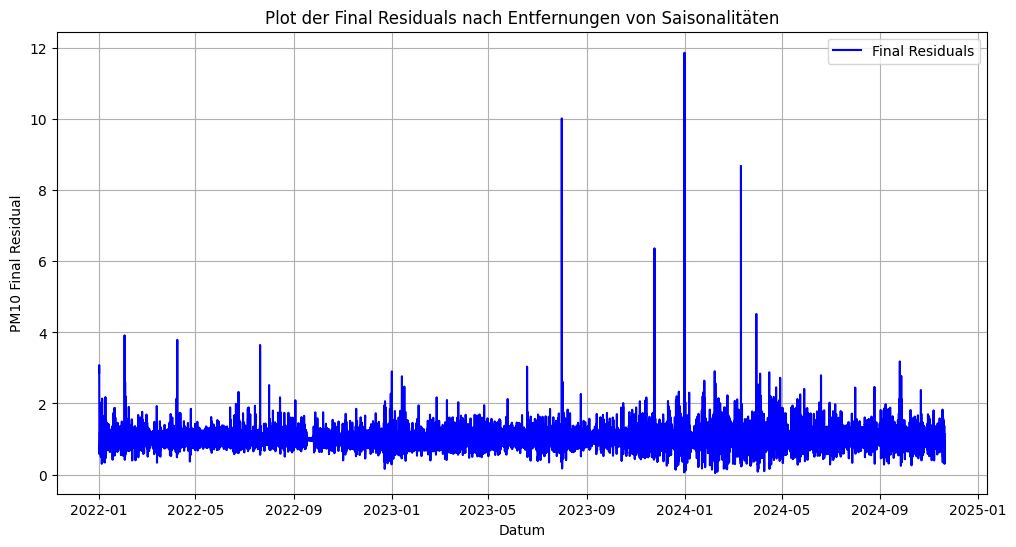

In [43]:
import matplotlib.pyplot as plt

# Sicherstellen, dass die Datum-Spalte als Datetime vorliegt
final_residual_data['Datum'] = pd.to_datetime(final_residual_data['Datum'])

# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(final_residual_data['Datum'], final_residual_data['PM10_Final_Residual'], label='Final Residuals', color='blue')

# Achsen und Titel hinzufügen
plt.xlabel('Datum')
plt.ylabel('PM10 Final Residual')
plt.title('Plot der Final Residuals nach Entfernungen von Saisonalitäten')
plt.legend()
plt.grid(True)

# Plot anzeigen
plt.show()

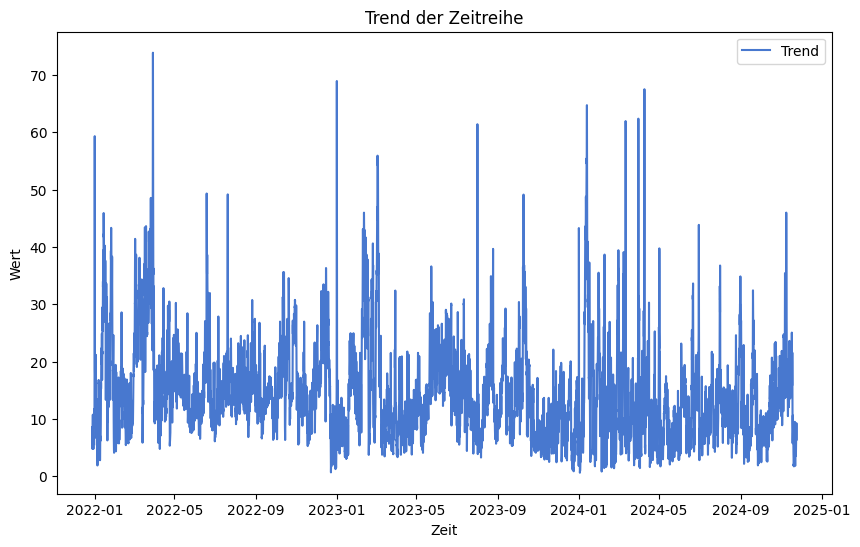

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Angenommen, 'series' ist deine Zeitreihendaten
# Beispiel: Anpassen der Periode an die Länge der Serie
period = 7  # Beispielperiode, passe sie an deine Daten an

# Durchführung der saisonalen Dekomposition
result = seasonal_decompose(series, model='multiplicative', period=period)

# Extrahieren der Trendkomponente
trend = result.trend

# Plotten der Trendkomponente
plt.figure(figsize=(10, 6))
plt.plot(trend, label='Trend')
plt.title('Trend der Zeitreihe')
plt.xlabel('Zeit')
plt.ylabel('Wert')
plt.legend()
plt.show()

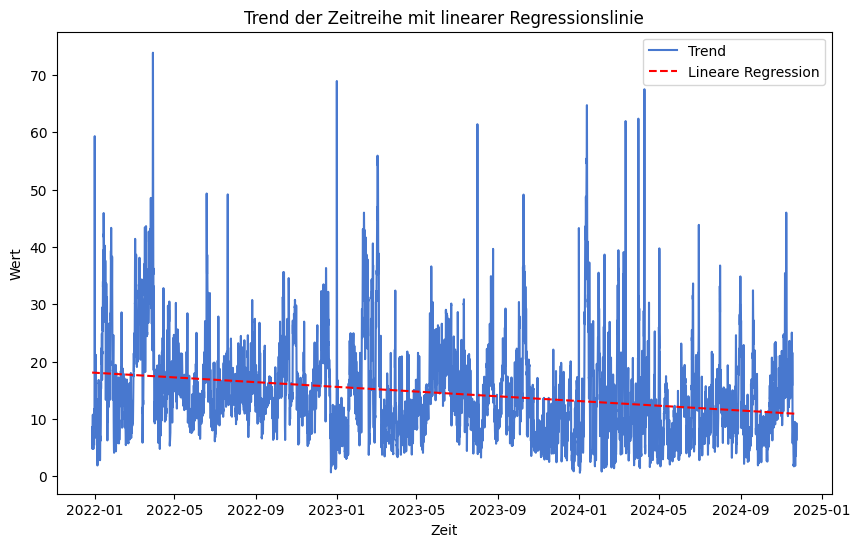

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

# Angenommen, 'series' ist deine Zeitreihendaten
# Beispiel: Anpassen der Periode an die Länge der Serie
period = 7  # Beispielperiode, passe sie an deine Daten an

# Durchführung der saisonalen Dekomposition
result = seasonal_decompose(series, model='multiplicative', period=period)

# Extrahieren der Trendkomponente
trend = result.trend.dropna()  # Entferne NaN-Werte

# Berechnung der linearen Regression
x = np.arange(len(trend))
y = trend.values
slope, intercept = np.polyfit(x, y, 1)
regression_line = slope * x + intercept

# Plotten der Trendkomponente und der linearen Regressionslinie
plt.figure(figsize=(10, 6))
plt.plot(trend, label='Trend')
plt.plot(trend.index, regression_line, color='red', linestyle='--', label='Lineare Regression')
plt.title('Trend der Zeitreihe mit linearer Regressionslinie')
plt.xlabel('Zeit')
plt.ylabel('Wert')
plt.legend()
plt.show()

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Spaltennamen ausgeben
print(filtered_data.columns)

# Sicherstellen, dass die 'Datum'-Spalte ein datetime-Format hat
filtered_data = filtered_data.reset_index()
filtered_data['Datum'] = pd.to_datetime(filtered_data['Datum'])

# Setze die 'Datum'-Spalte als Index
filtered_data.set_index('Datum', inplace=True)

# Auswahl der Zeitreihe (PM10 Mittelwerte)
series = filtered_data['PM10 (Stundenmittelwerte)']

# 1. Wöchentliche Saisonalität entfernen
weekly_result = seasonal_decompose(series, model='multiplicative', period=168)
residuals_after_weekly = weekly_result.resid.dropna()
trend_after_weekly = weekly_result.trend.dropna()

# 2. Tägliche Saisonalität auf den Residuen entfernen
daily_result = seasonal_decompose(residuals_after_weekly, model='multiplicative', period=24)
final_residuals = daily_result.resid.dropna()
trend_after_daily = daily_result.trend.dropna()

# Kombinieren von Trend und Residual-Komponenten
# Da das Modell multiplikativ ist, müssen wir die Komponenten multiplizieren
combined_trend_residual = trend_after_weekly * final_residuals

# Neues DataFrame mit den kombinierten Trend-Residualen
combined_trend_residual_data = combined_trend_residual.reset_index()
combined_trend_residual_data.columns = ['Datum', 'PM10_Combined_Trend_Residual']

# Filtere die Daten basierend auf den Start- und Enddaten des finalDataFrame

# Filtere die Daten ab dem 1.1.2022 0:00 Uhr bis zum 21.10.2024 14:00 Uhr
start_date = '2022-01-01 01:00:00'
end_date = '2024-10-21 15:00:00'
filtered_combined_trend_residual_data = combined_trend_residual_data.loc[
    (combined_trend_residual_data['Datum'] >= start_date) & 
    (combined_trend_residual_data['Datum'] <= end_date)
].copy()

# Offset von -1 Stunde anwenden
filtered_combined_trend_residual_data['Datum'] = filtered_combined_trend_residual_data['Datum'] + pd.Timedelta(hours=-1)

# Kombiniertes Trend-Residual-Dataset anzeigen
print(filtered_combined_trend_residual_data.head())
print(filtered_combined_trend_residual_data.tail())

Index(['PM10 (Stundenmittelwerte)'], dtype='object')
                       Datum  PM10_Combined_Trend_Residual
13 2022-01-01 00:00:00+00:00                     40.203491
14 2022-01-01 01:00:00+00:00                     29.962952
15 2022-01-01 02:00:00+00:00                     22.267443
16 2022-01-01 03:00:00+00:00                     18.855161
17 2022-01-01 04:00:00+00:00                     12.048827
                          Datum  PM10_Combined_Trend_Residual
24599 2024-10-21 10:00:00+00:00                      8.670885
24600 2024-10-21 11:00:00+00:00                      9.332883
24601 2024-10-21 12:00:00+00:00                     11.542000
24602 2024-10-21 13:00:00+00:00                     12.790261
24603 2024-10-21 14:00:00+00:00                     11.483849


In [47]:
# Residual-Daten in eine CSV-Datei speichern
filtered_combined_trend_residual_data.to_csv("../Final_Data/Cleaned/Final_Target_Data_Combined_resid_Trend.csv", index=False)

print("CSV-Datei erfolgreich gespeichert.")

CSV-Datei erfolgreich gespeichert.


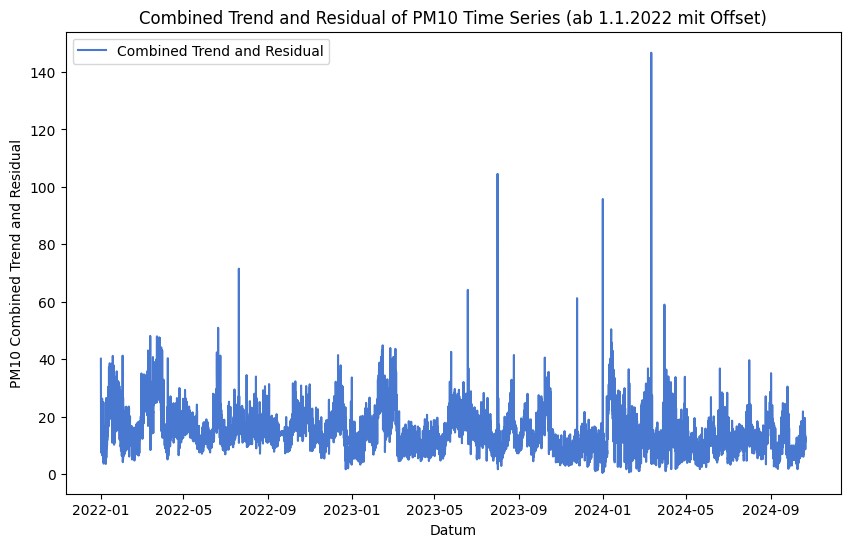

In [48]:
# Plotten der kombinierten Trend- und Residual-Komponente ab dem 1.1.2022 mit Offset
plt.figure(figsize=(10, 6))
plt.plot(filtered_combined_trend_residual_data['Datum'], filtered_combined_trend_residual_data['PM10_Combined_Trend_Residual'], label='Combined Trend and Residual')
plt.title('Combined Trend and Residual of PM10 Time Series (ab 1.1.2022 mit Offset)')
plt.xlabel('Datum')
plt.ylabel('PM10 Combined Trend and Residual')
plt.legend()
plt.show()